# **Importing libraries**

In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import RobustScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split
from scipy.optimize import linear_sum_assignment
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import re
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# **Fetching and preparing data**

## Fetching data

In [34]:
news = fetch_20newsgroups(subset = 'all', remove = ('headers', 'footers', 'quotes'))
categories = news.target_names
print(categories)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [35]:
news_df = pd.DataFrame({'text':news.data, 'target':news.target})
news_df['target_name'] = news_df['target'].apply(lambda x: categories[x])
news_df.head()

,text,target,target_name
0,\n\nI am sure some bashers of Pens fans are pr...,10,rec.sport.hockey
1,My brother is in the market for a high-perform...,3,comp.sys.ibm.pc.hardware
2,\n\n\n\n\tFinally you said what you dream abou...,17,talk.politics.mideast
3,\nThink!\n\nIt's the SCSI card doing the DMA t...,3,comp.sys.ibm.pc.hardware
4,1) I have an old Jasmine drive which I cann...,4,comp.sys.mac.hardware


## Helper functions to select a subset from the data

In [36]:
def get_random_n_categories(n, df, seed=3002):
    np.random.seed(seed)
    random_categories = np.random.choice(categories, n, replace = False)
    return random_categories

def get_subset_df(df, selected_categories):
    df = df.copy()
    df = df[df['target_name'].isin(selected_categories)]
    df['target'] = df['target'].apply(lambda x: np.where(selected_categories == categories[x])[0][0])
    return df

In [37]:
n_categories = 6
selected_categories = get_random_n_categories(n_categories, news_df)
print("Selected categories: ", selected_categories)
df = get_subset_df(news_df, selected_categories)
df.head()

Selected categories:  ['comp.graphics' 'talk.politics.misc' 'rec.sport.hockey' 'misc.forsale'
 'alt.atheism' 'comp.sys.mac.hardware']


,text,target,target_name
0,\n\nI am sure some bashers of Pens fans are pr...,2,rec.sport.hockey
4,1) I have an old Jasmine drive which I cann...,5,comp.sys.mac.hardware
6,\n\nAE is in Dallas...try 214/241-6060 or 214/...,5,comp.sys.mac.hardware
7,"\n[stuff deleted]\n\nOk, here's the solution t...",2,rec.sport.hockey
8,"\n\n\nYeah, it's the second one. And I believ...",2,rec.sport.hockey


## Preprocessing

In [38]:
def preprocess(text):
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Removing digits
    text = re.sub(r'\s+', ' ', text)  # Removing extra whitespace
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuation
    text = re.sub(r'\b\w{25,}\b', '', text)  # Removing long words
    text = re.sub(r'\S+@\S+', '', text)  # Removing emails
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Removing URLs
    text = re.sub(r'[^\x00-\x7F]+', '', text) #removing non-ASCII characters
    text = re.sub(r'<.*?>', '', text) #removing HTML tags
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)

In [39]:
df['text'] = df['text'].apply(preprocess)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df['text']), np.array(df['target']), test_size=0.2, random_state=42)

# **Functions definitions**

## `1` purity score

In [41]:
def purity_score(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

## `2` Assigning each cluster a unique label (from the known set) using the Hungarian algorithm to maximize the total number of correctly assigned samples.

In [42]:
def assign_clusters(y_true, y_pred):
    cm = contingency_matrix(y_true, y_pred)
    n_labels, n_clusters = cm.shape
    M = cm.T
    if n_clusters != n_labels:
        raise ValueError(
            f"Number of clusters ({n_clusters}) != number of labels ({n_labels}).\n"
            "A one-to-one assignment is only well-defined if they match.\n"
            "If they differ, you can still do a max bipartite matching but you'll have leftover nodes."
        )
    cost = -M
    row_ind, col_ind = linear_sum_assignment(cost)
    cluster_to_label = {}
    for cluster_id, label_idx in zip(row_ind, col_ind):
        cluster_to_label[cluster_id] = selected_categories[label_idx]

    return cluster_to_label


## `3` Counting the number of examples assigned to each cluster

In [43]:
def count_examples(y_true, y_pred, true_labels):
    pred_labels = assign_clusters(y_true, y_pred)
    true_counts = {}
    pred_counts = {}
    for y in y_true:
        if true_labels[y] in true_counts:
          true_counts[str(true_labels[y])] += 1
        else:
          true_counts[str(true_labels[y])] = 1
    for y in y_pred:
        if pred_labels[y] in pred_counts:
          pred_counts[str(pred_labels[y])] += 1
        else:
          pred_counts[str(pred_labels[y])] = 1
    return true_counts, pred_counts

## `4` Visualizing the distribution of the predicted labels vs the true labels

In [44]:
def visualize_counts(y_train, y_pred, title):
    cnt_true, cnt_pred = count_examples(y_train, y_pred, selected_categories)
    y_true_plot = []
    y_pred_plot = []
    labels = []
    x_spaces = np.arange(n_categories)
    width = .35
    for cat in selected_categories:
        y_true_plot.append(cnt_true[str(cat)])
        y_pred_plot.append(cnt_pred[str(cat)])
        labels.append(cat)
    plt.figure(figsize=(10, 6))
    plt.bar(x_spaces - width/2, y_true_plot, width, label='True')
    plt.bar(x_spaces + width/2, y_pred_plot, width, label='Predicted')
    plt.xlabel('Categories')
    plt.ylabel('Count')
    plt.xticks(x_spaces,labels, rotation=70)
    plt.title(title)
    plt.legend()
    plt.show()

## `6` PCA visualization of the clusters

In [45]:
def pca_visualization(X_pca, y_pred, cluster_centers, target_names):

    unique_labels = np.unique(y_pred)
    palette = sns.color_palette("hls", len(unique_labels))

    plt.figure(figsize=(10, 10))
    for label, color in zip(unique_labels, palette):
        mask = (y_pred == label)
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                    label=str(target_names[label]), color=color, alpha=0.7)

    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='darkred', marker='X', s=200, label="Cluster Centers")

    plt.legend(title="Clusters")
    plt.title("PCA Visualization of Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

## `7` TSNE visualization of the clusters

In [46]:
def tsne_visualization(X_tsne, y_pred, cluster_centers, target_names):

    unique_labels = np.unique(y_pred)
    palette = sns.color_palette("hls", len(unique_labels))

    plt.figure(figsize=(10, 10))
    for label, color in zip(unique_labels, palette):
        mask = (y_pred == label)
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                    label=str(target_names[label]), color=color, alpha=0.7)

    plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], color='darkred', marker='X', s=200, label="Cluster Centers")

    plt.legend(title="Clusters")
    plt.title("t-SNE Visualization of Clusters")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

# **Trial `1` Using vectorization, TSNE, and kmeans**

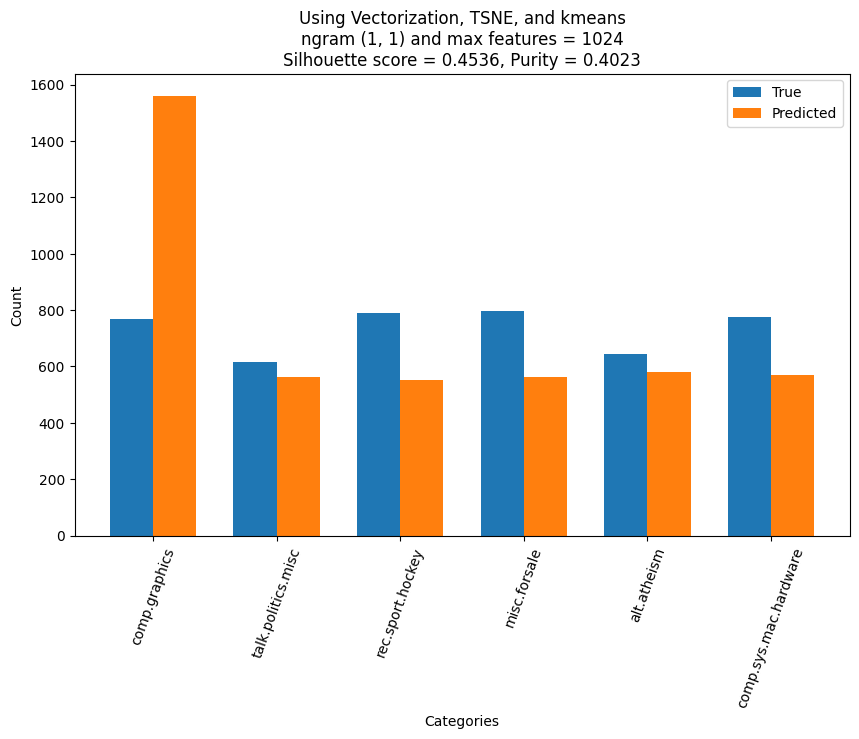

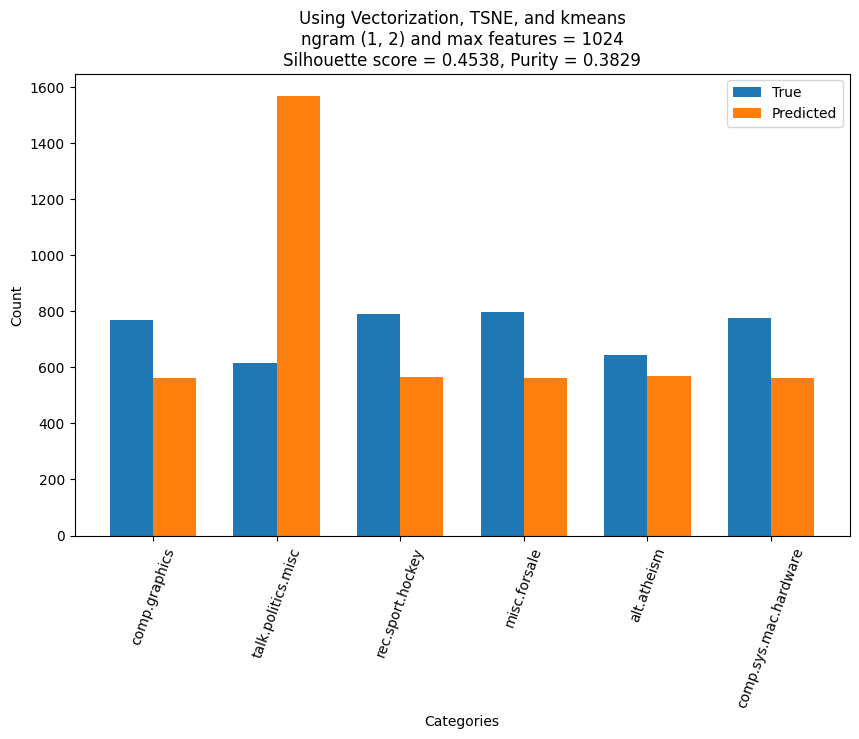

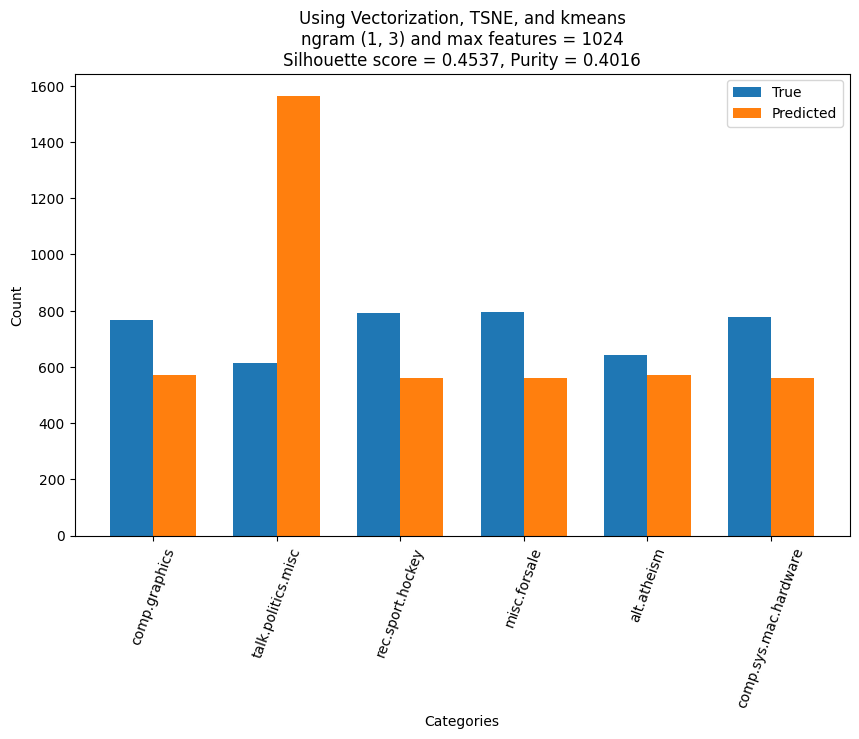

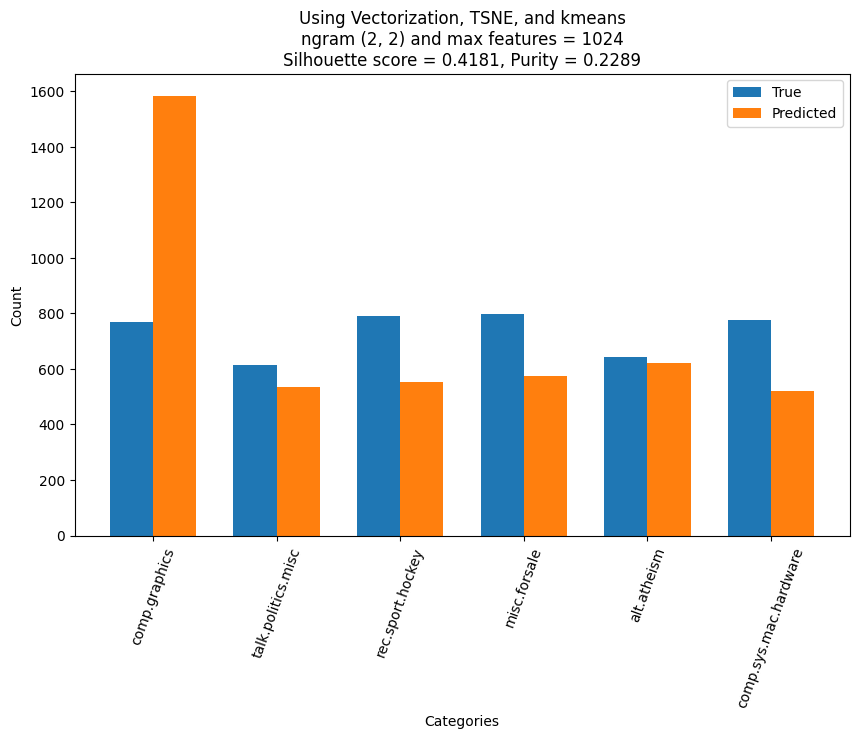

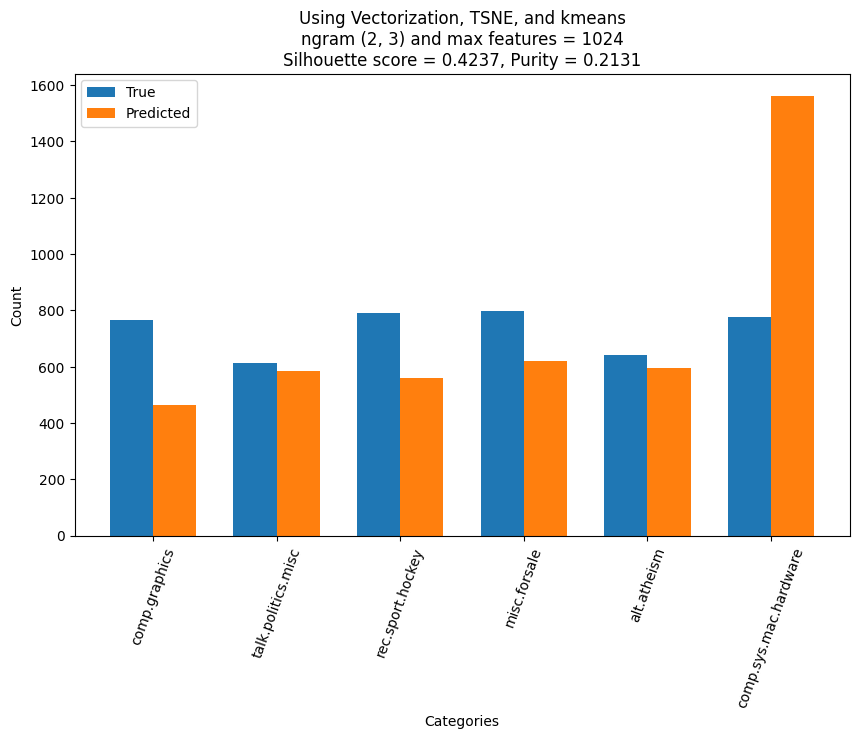

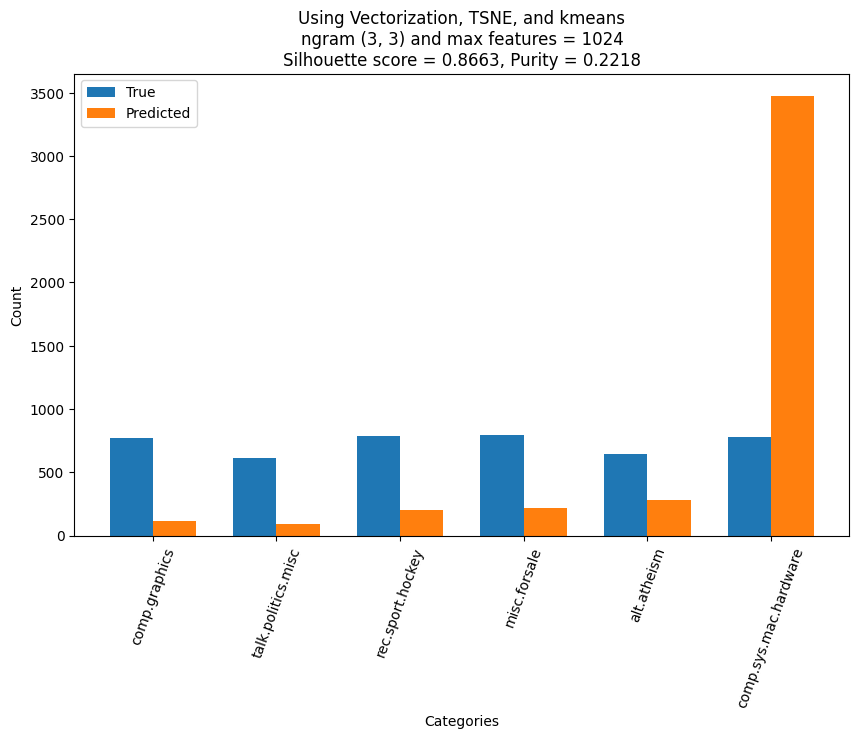

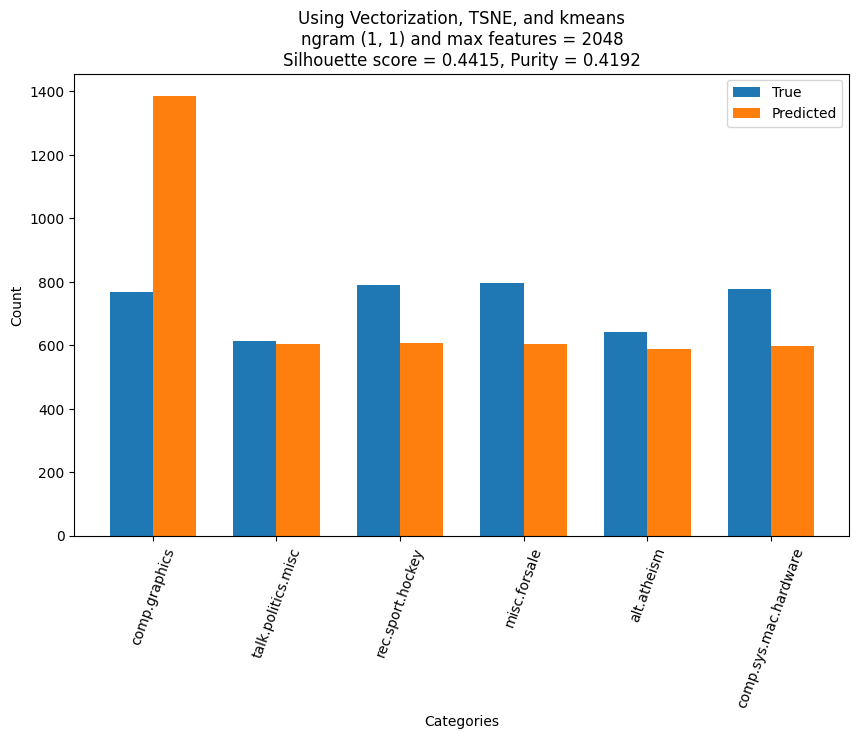

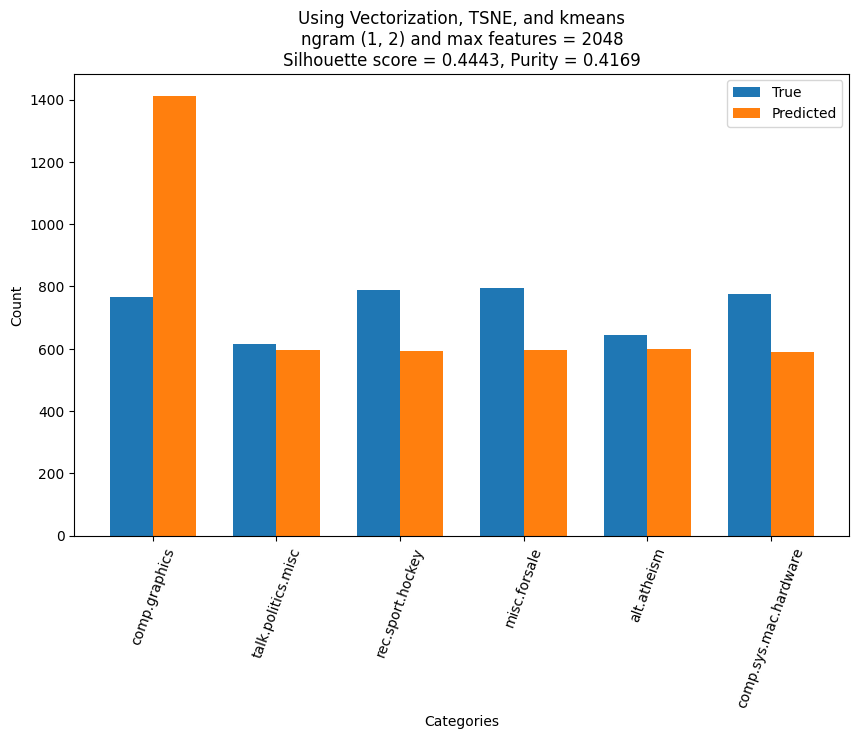

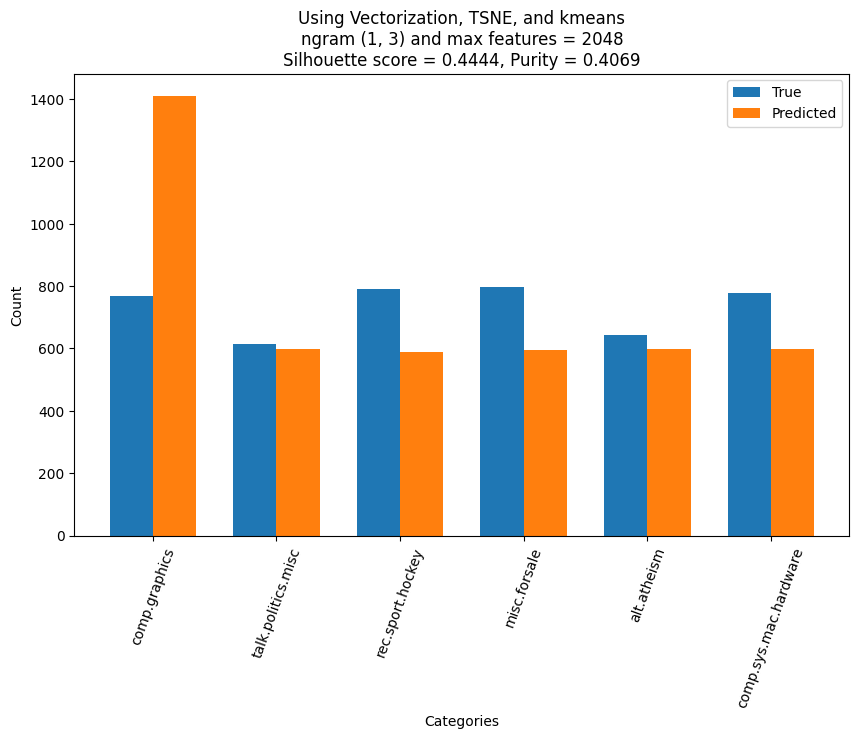

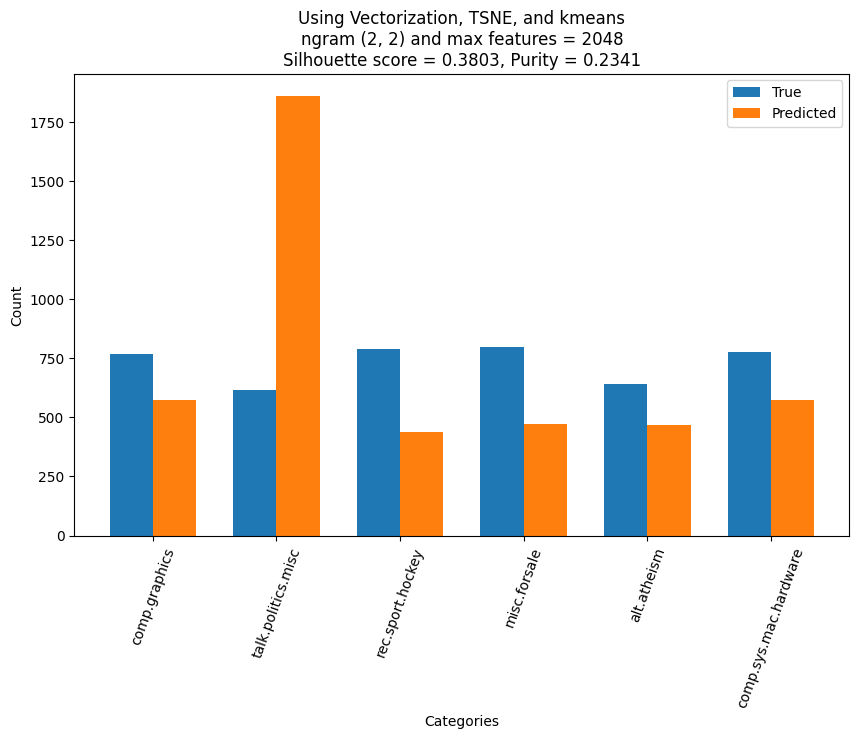

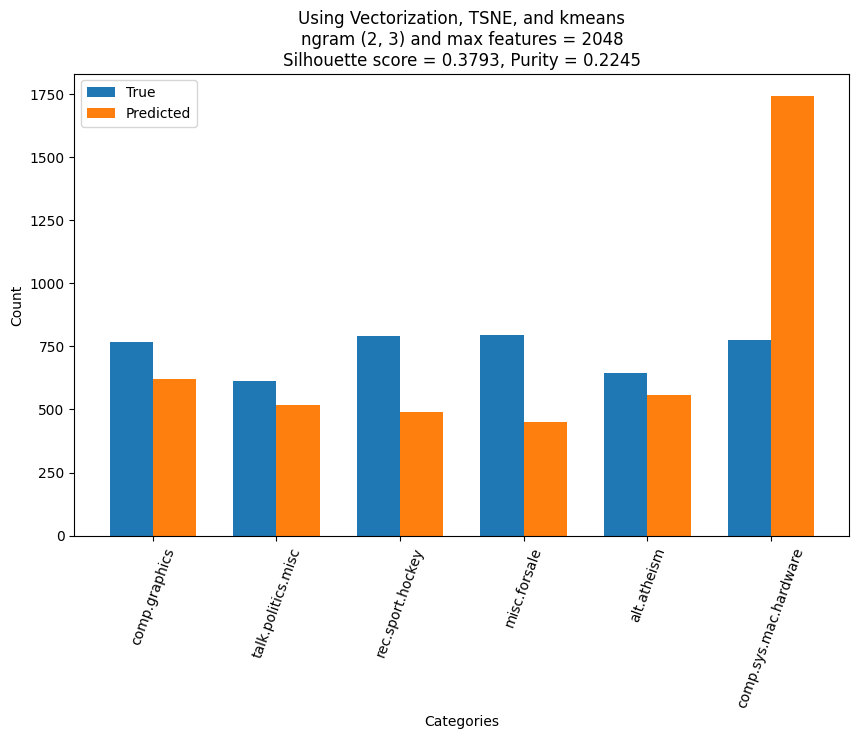

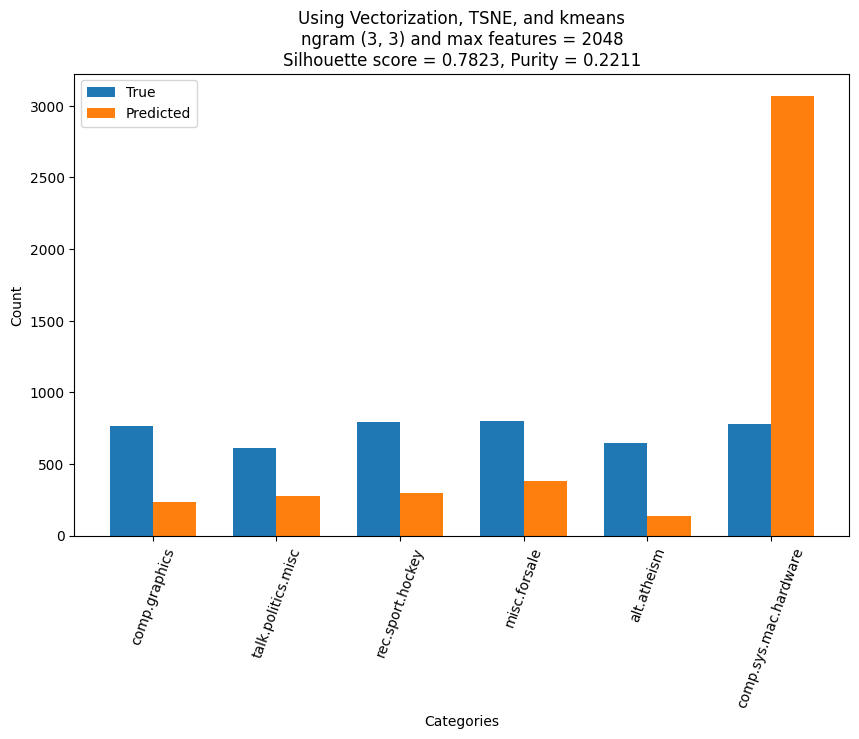

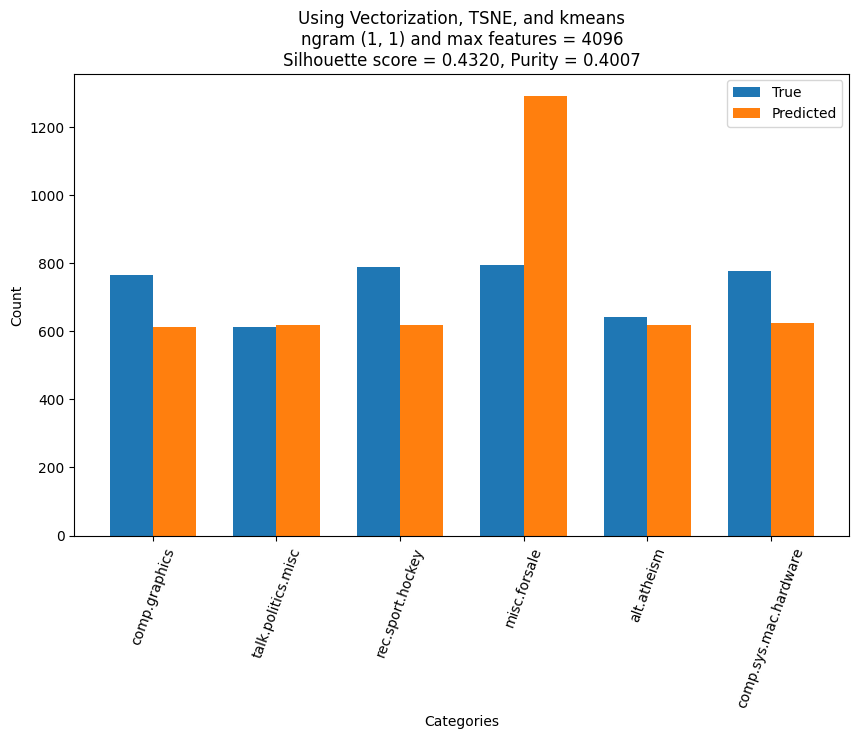

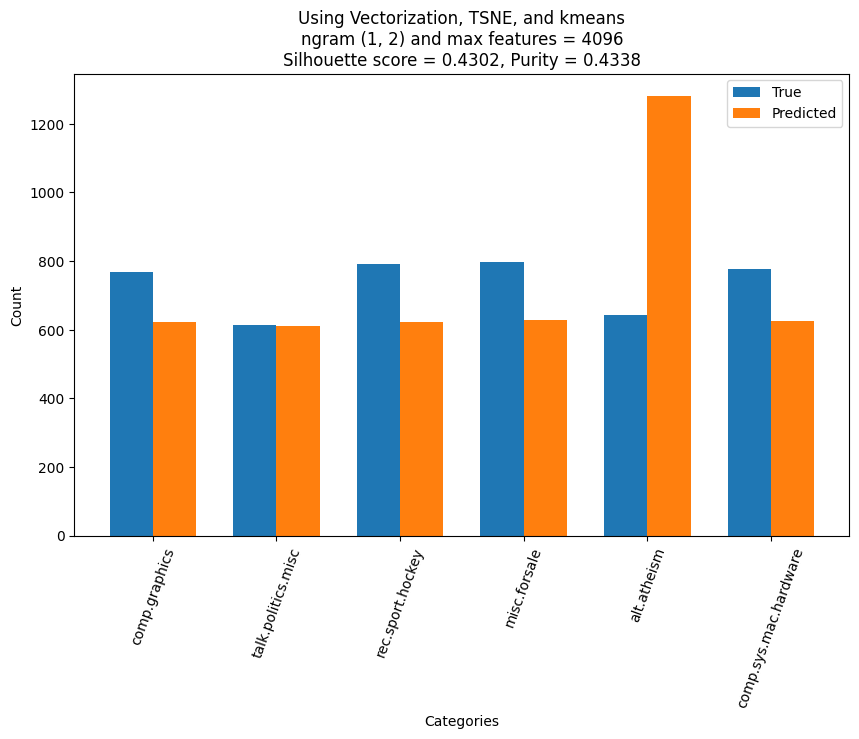

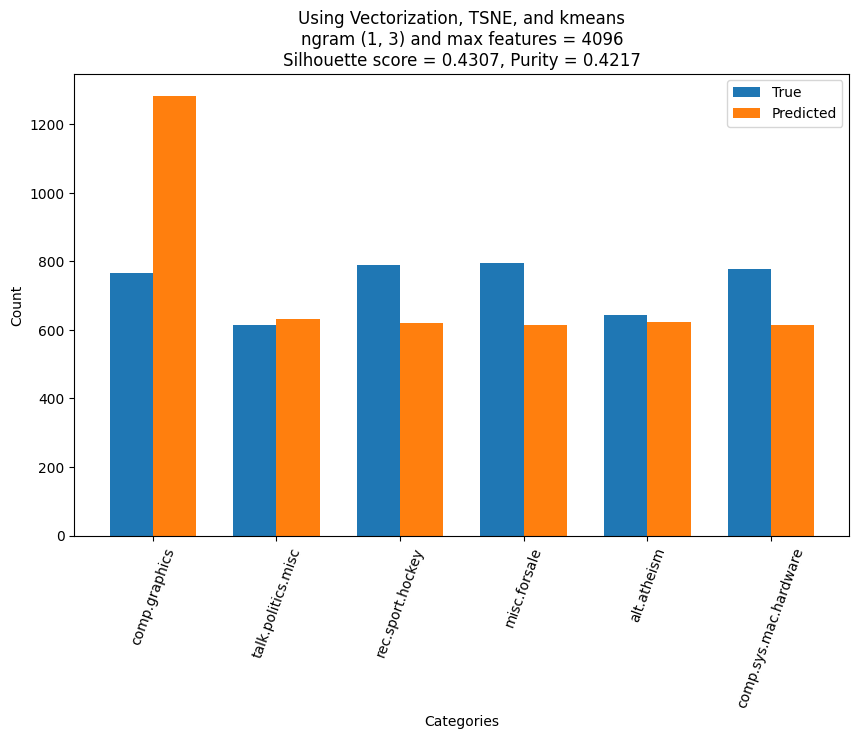

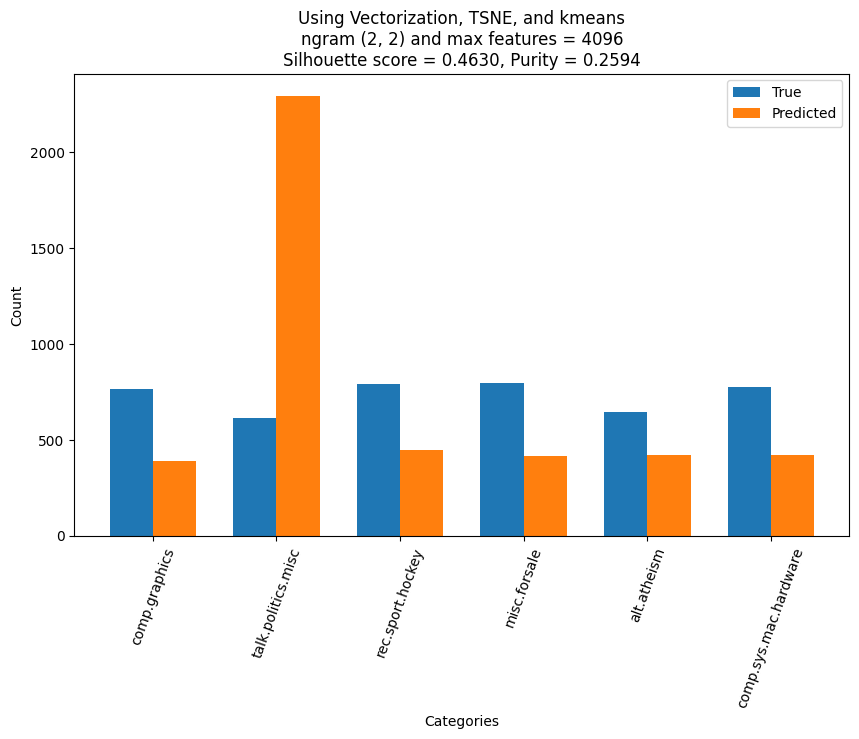

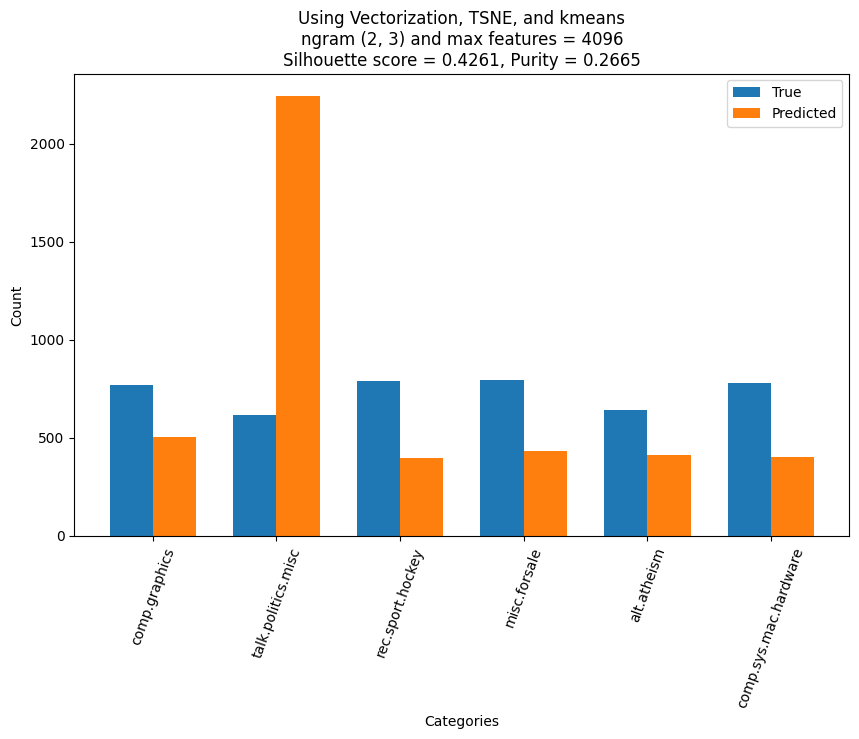

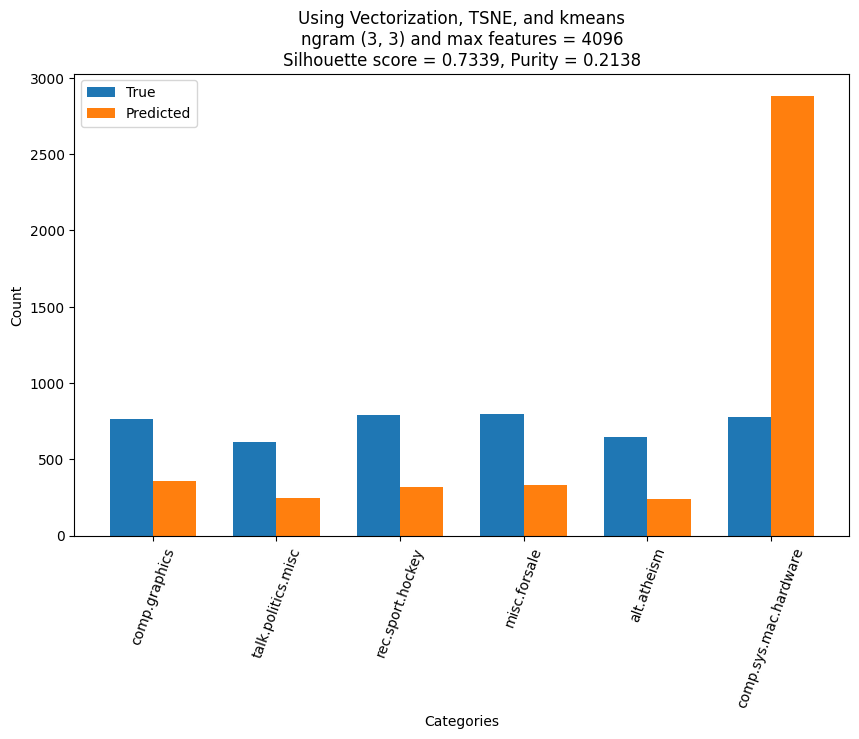

In [47]:
ngrams = []
for i in range(1,4):
    for j in range(i,4):
        ngrams.append((i,j))
max_features_list = [1024,2048,4096]
for max_features in max_features_list:
    for ngarm in ngrams:
        vectorizer = TfidfVectorizer(ngram_range=ngarm, max_features=max_features)
        X_train_vectorized = vectorizer.fit_transform(X_train)
        tsne = TSNE(perplexity = 50, random_state=42)
        X_train_tsne = tsne.fit_transform(X_train_vectorized.toarray())
        model = KMeans(n_clusters=n_categories, random_state=42)
        model.fit(X_train_tsne)
        y_pred = model.predict(X_train_tsne)
        silhouette_avg = silhouette_score(X_train_tsne, y_pred)
        purity = purity_score(y_train, y_pred)
        title = f'Using Vectorization, TSNE, and kmeans\nngram {ngarm} and max features = {max_features}\nSilhouette score = {silhouette_avg:.4f}, Purity = {purity:.4f}'
        visualize_counts(y_train, y_pred, title)


### After analyzing the scores and the graphs, the arguments `ngram_range=(1,3)` and `max_features=4096` seem to yeild good results

Silhouette score = 0.4307, Purity = 0.4217


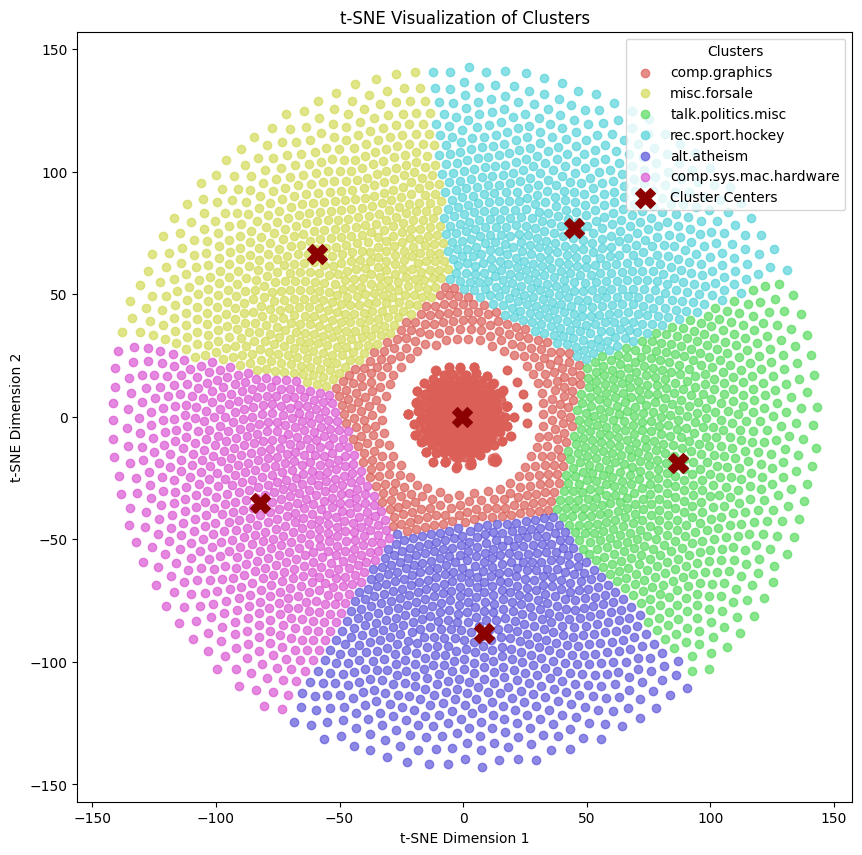

In [48]:
vectorizer = TfidfVectorizer(ngram_range=(1,3), max_features=4096)
X_train_vectorized = vectorizer.fit_transform(X_train)
tsne = TSNE(perplexity = 50, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_vectorized.toarray())
model = KMeans(n_clusters=n_categories, random_state=42)
model.fit(X_train_tsne)
y_pred = model.predict(X_train_tsne)
silhouette_avg = silhouette_score(X_train_tsne, y_pred)
purity = purity_score(y_train, y_pred)
labels = assign_clusters(y_train, y_pred)
print(f"Silhouette score = {silhouette_avg:.4f}, Purity = {purity:.4f}")
tsne_visualization(X_train_tsne, y_pred, model.cluster_centers_, labels)

# **Trial `2` Using vectorization, PCA, and kmeans**

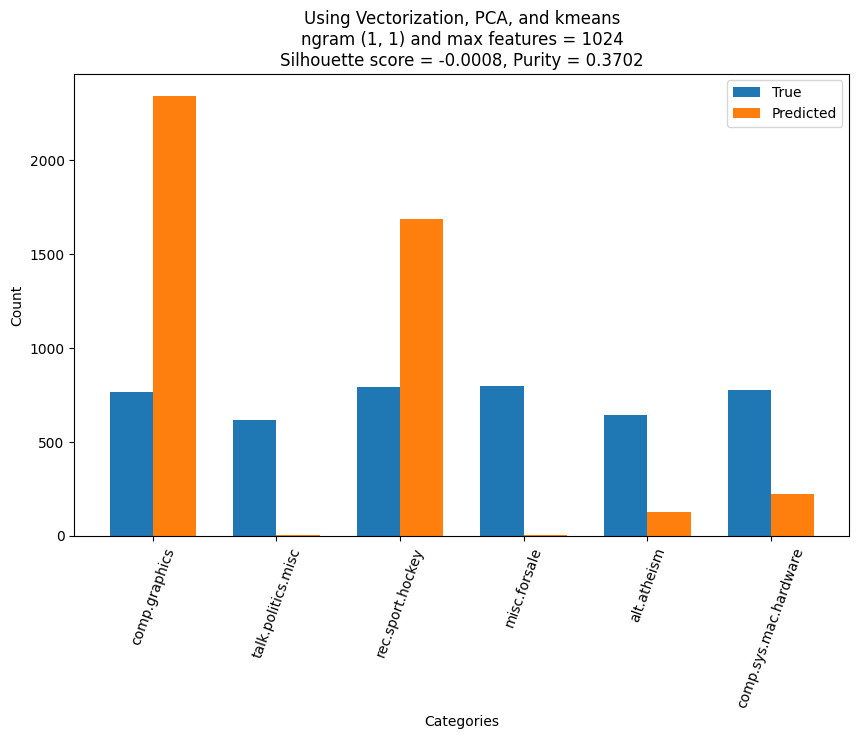

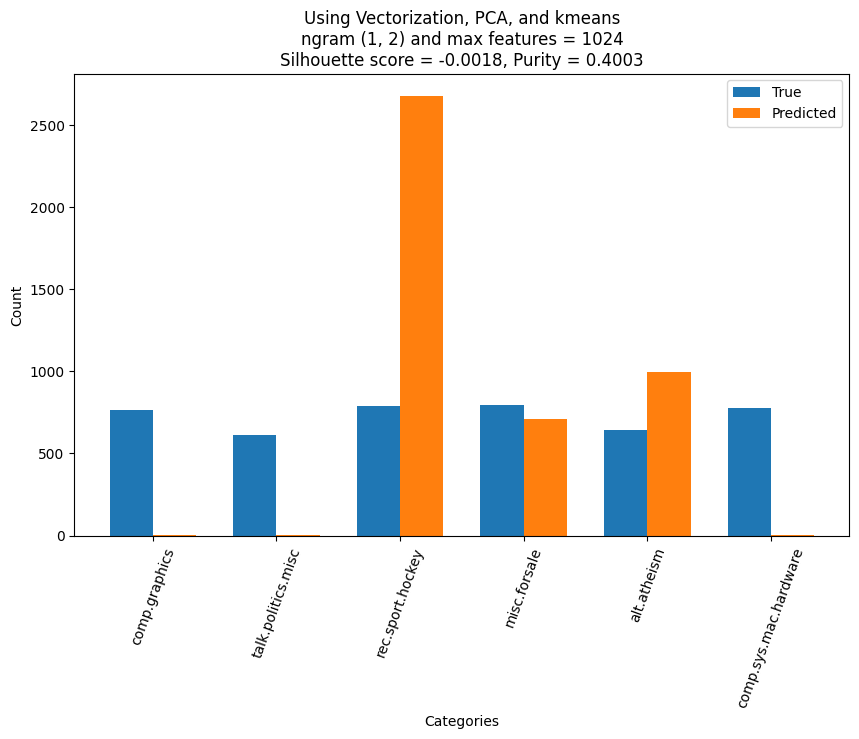

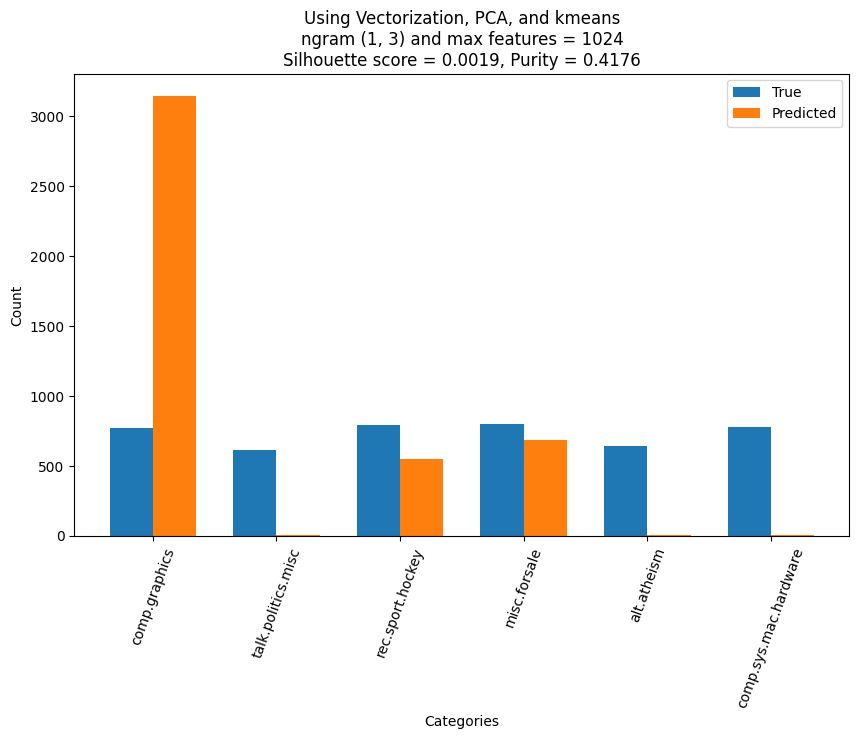

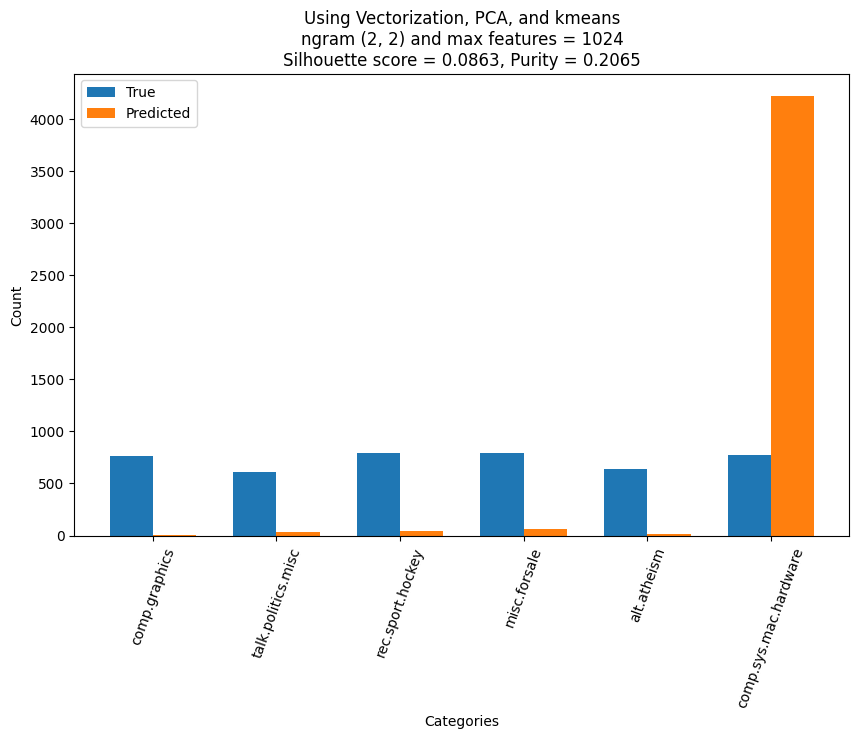

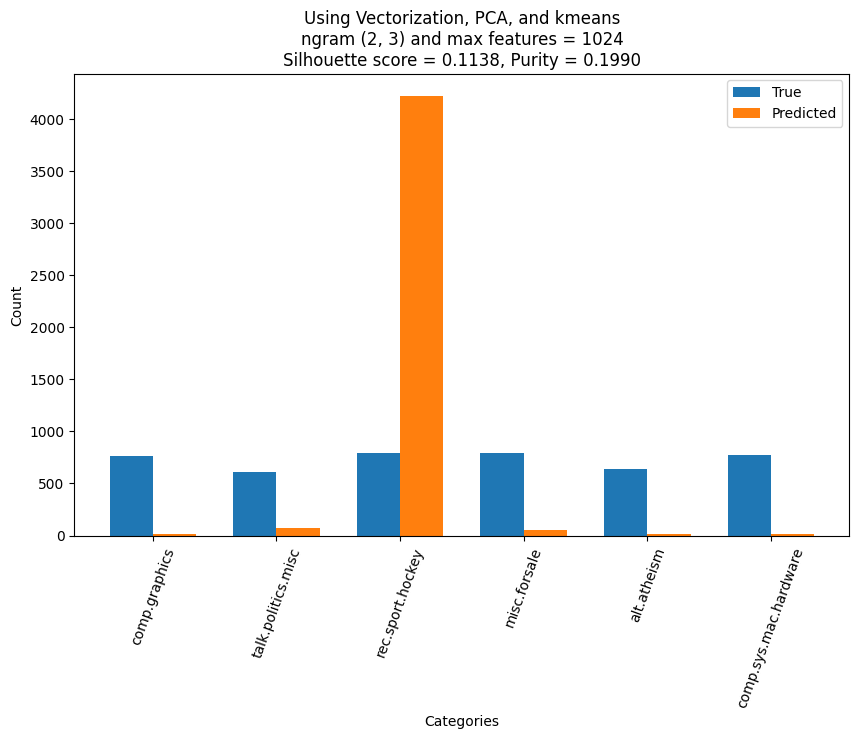

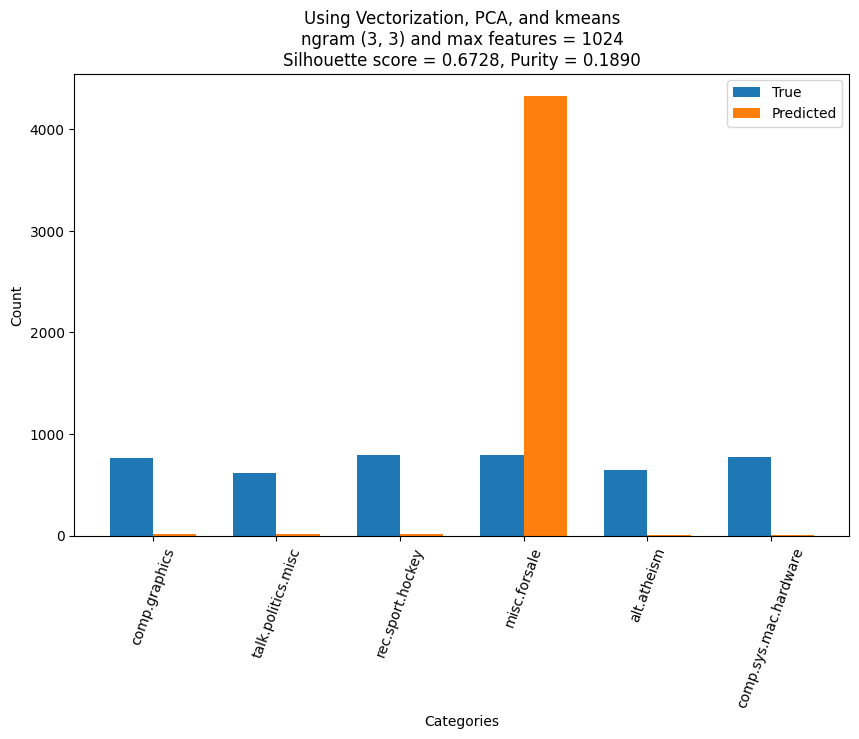

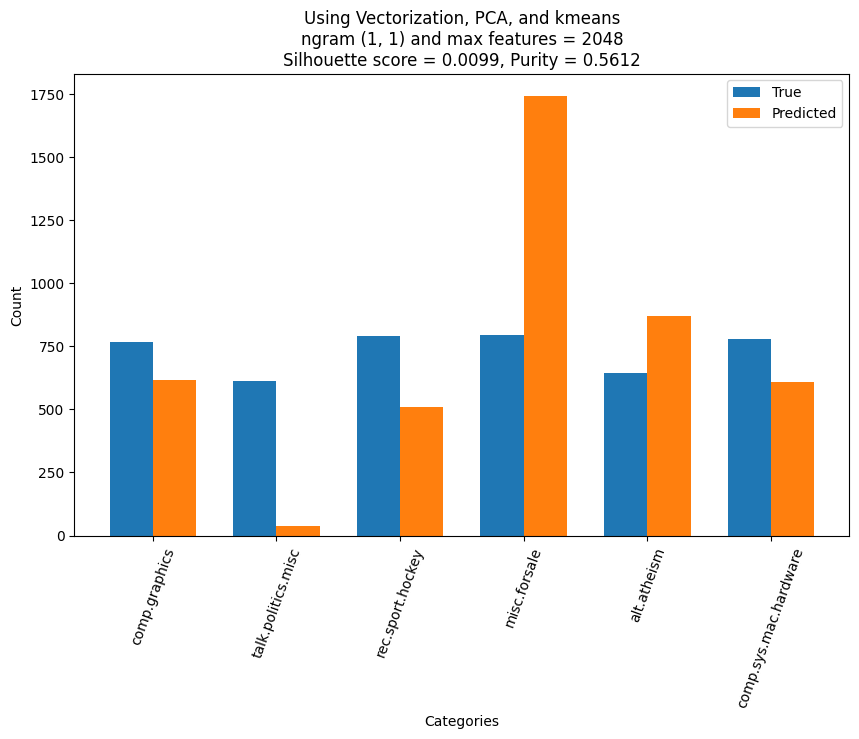

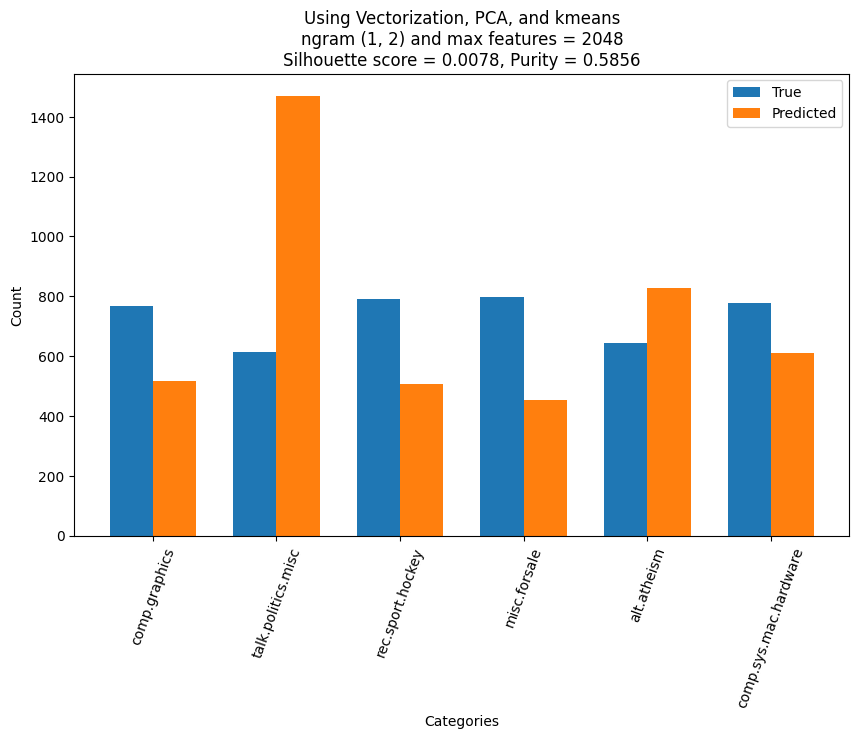

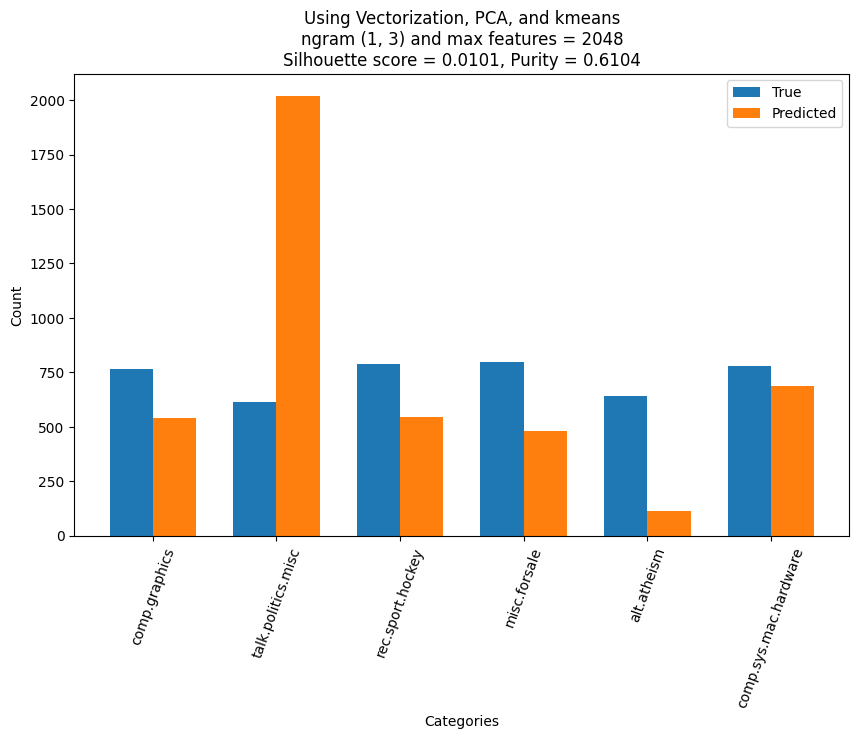

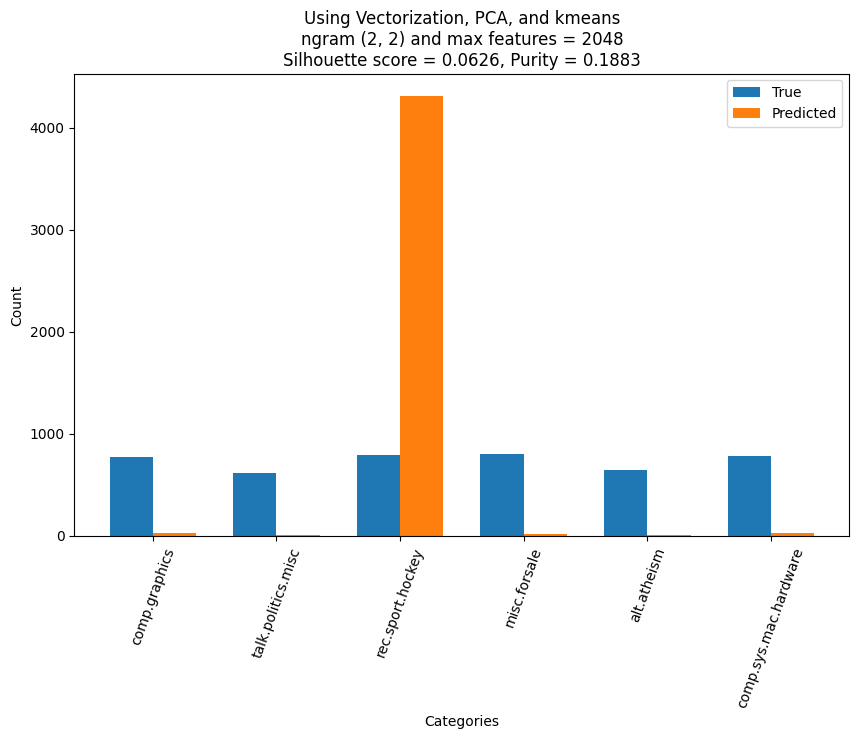

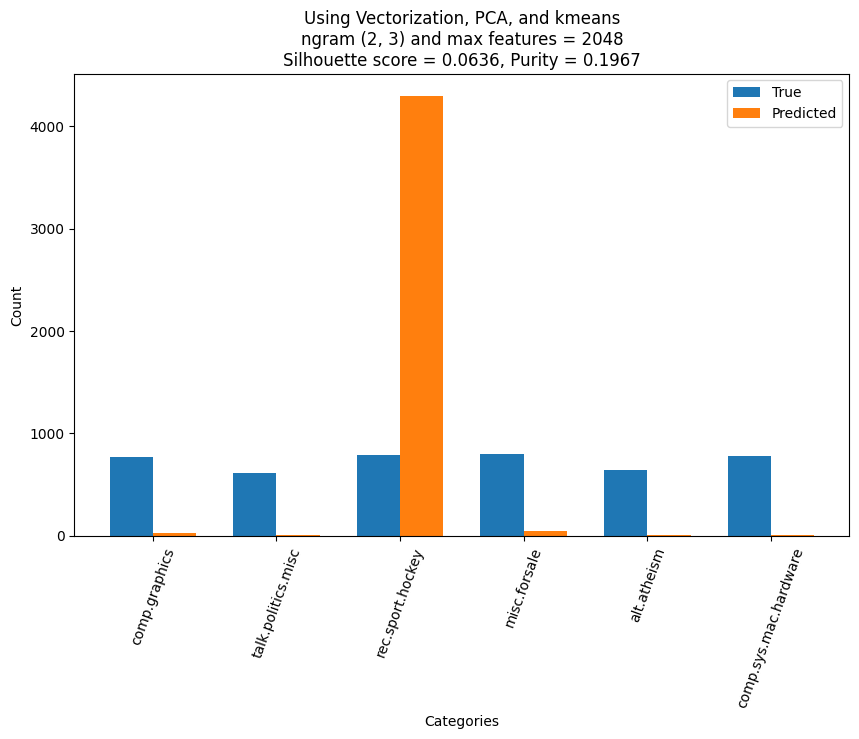

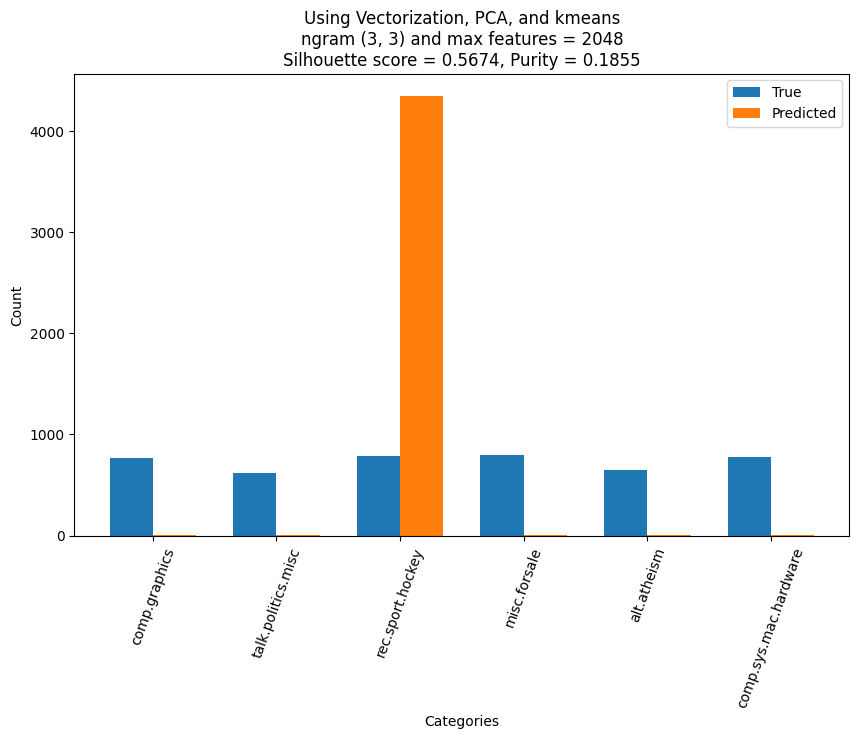

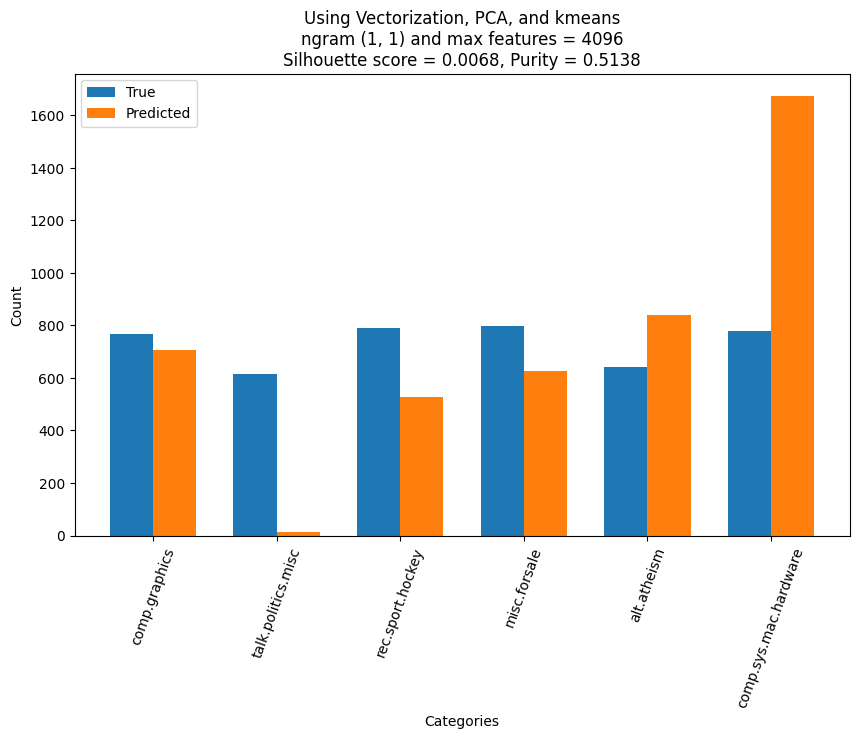

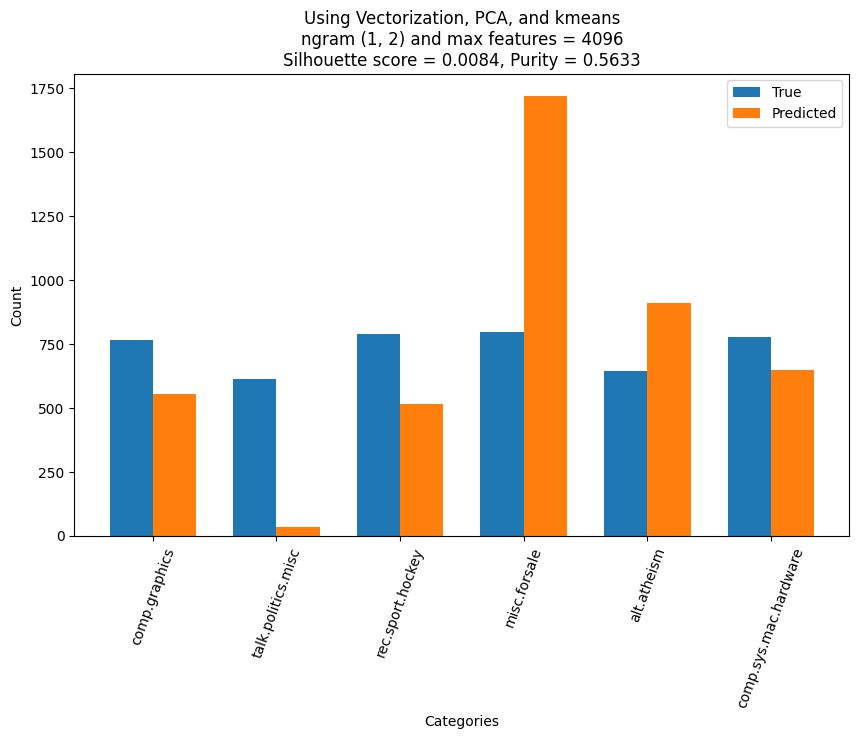

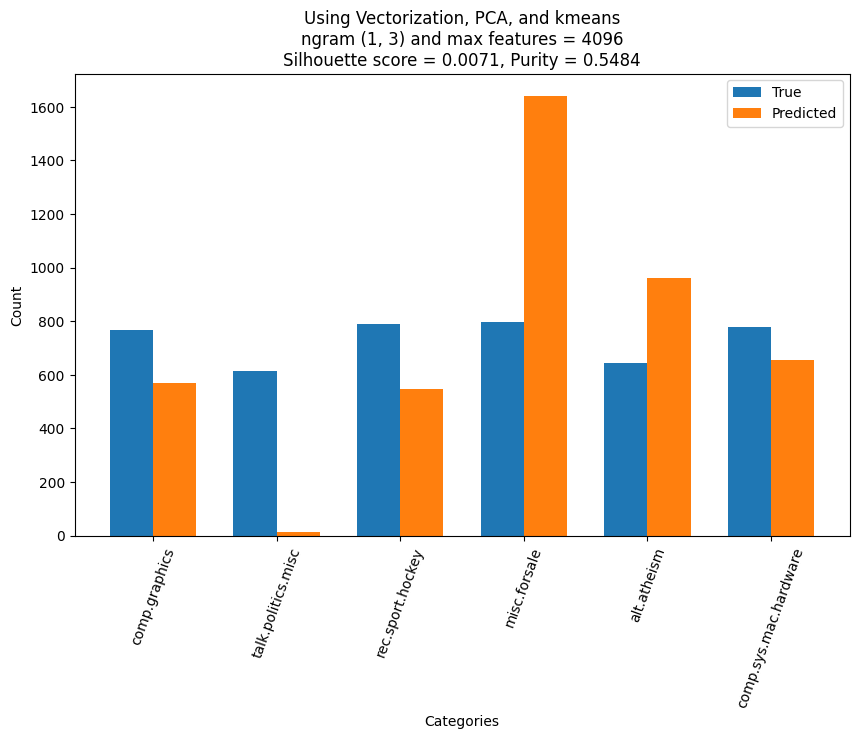

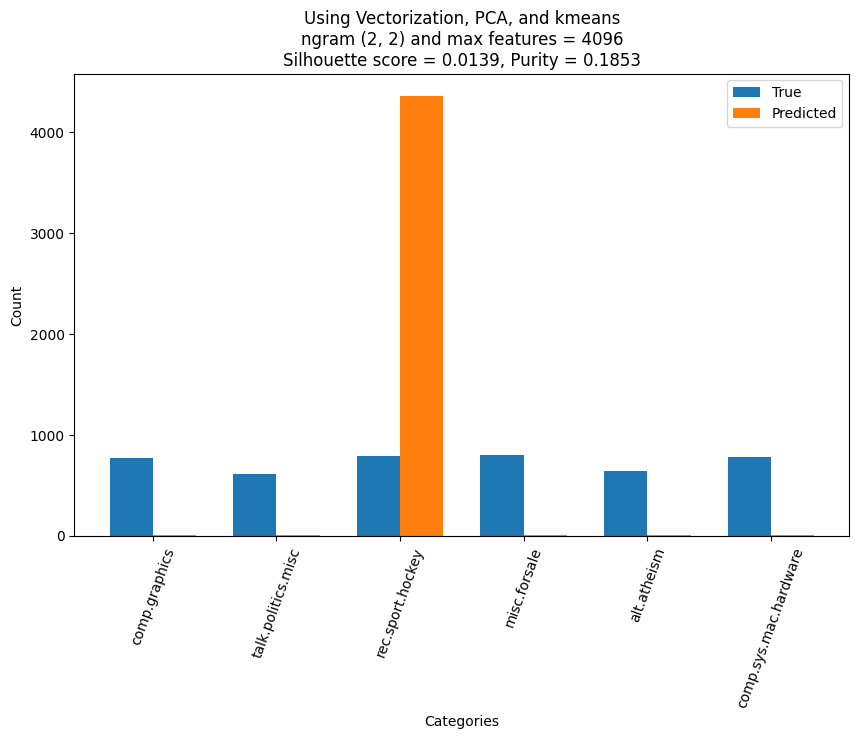

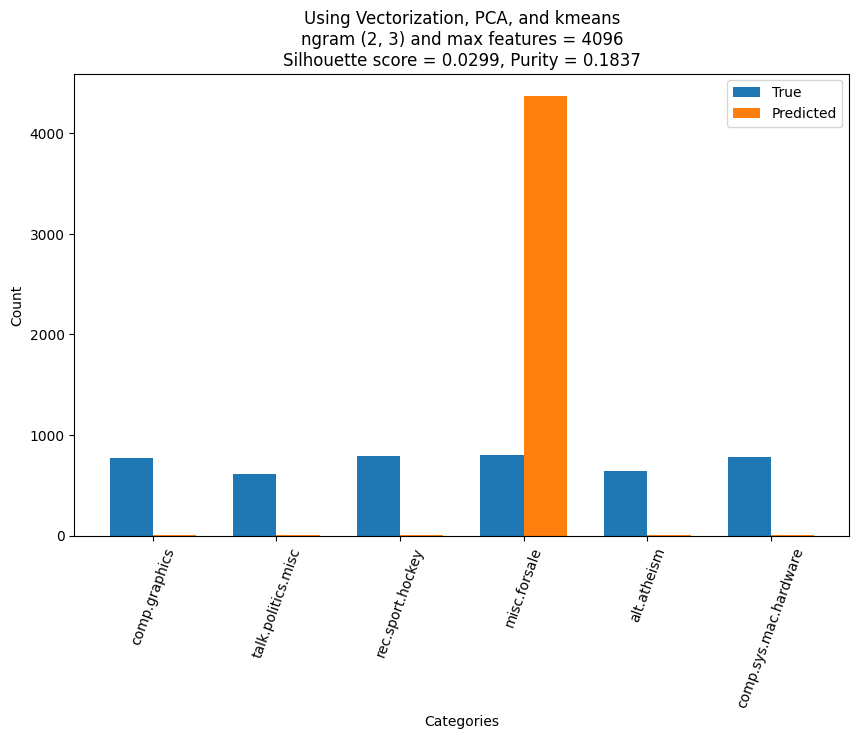

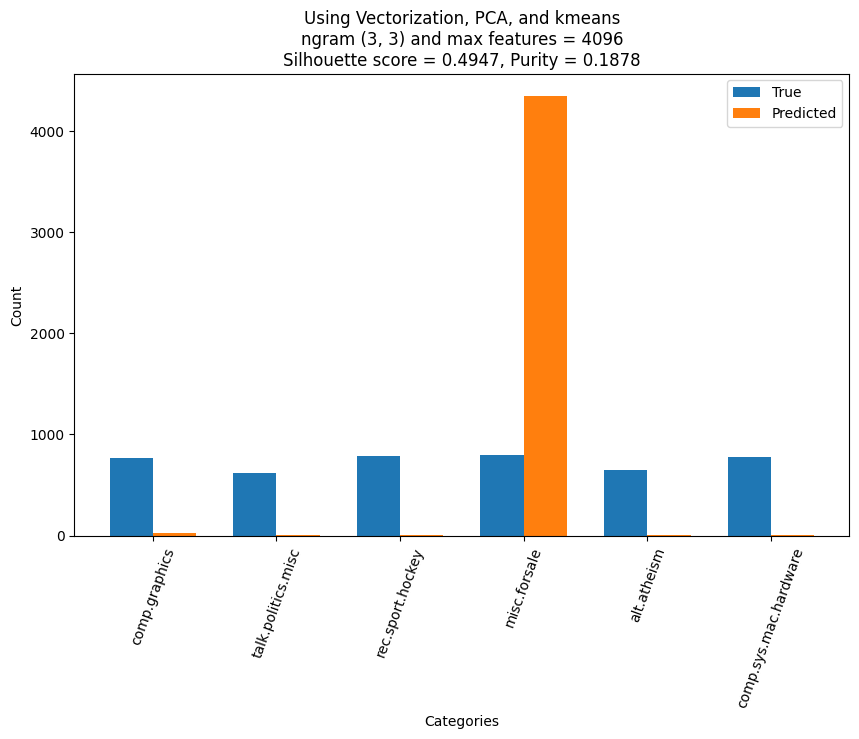

In [57]:
ngrams = []
for i in range(1,4):
    for j in range(i,4):
        ngrams.append((i,j))
max_features_list = [1024,2048,4096]
for max_features in max_features_list:
    for ngarm in ngrams:
        vectorizer = TfidfVectorizer(ngram_range=ngarm, max_features=max_features)
        X_train_vectorized = vectorizer.fit_transform(X_train)
        pca = PCA(n_components=.9, random_state=42)
        X_train_pca = pca.fit_transform(X_train_vectorized.toarray())
        model = KMeans(n_clusters=n_categories, random_state=42)
        model.fit(X_train_pca)
        y_pred = model.predict(X_train_pca)
        silhouette_avg = silhouette_score(X_train_pca, y_pred)
        purity = purity_score(y_train, y_pred)
        title = f'Using Vectorization, PCA, and kmeans\nngram {ngarm} and max features = {max_features}\nSilhouette score = {silhouette_avg:.4f}, Purity = {purity:.4f}'
        visualize_counts(y_train, y_pred, title)


### After analyzing the scores and the graphs, the arguments `ngram_range=(1,2)` and `max_features=2048` seem to yeild good results

Silhouette score = 0.0078, Purity = 0.5856


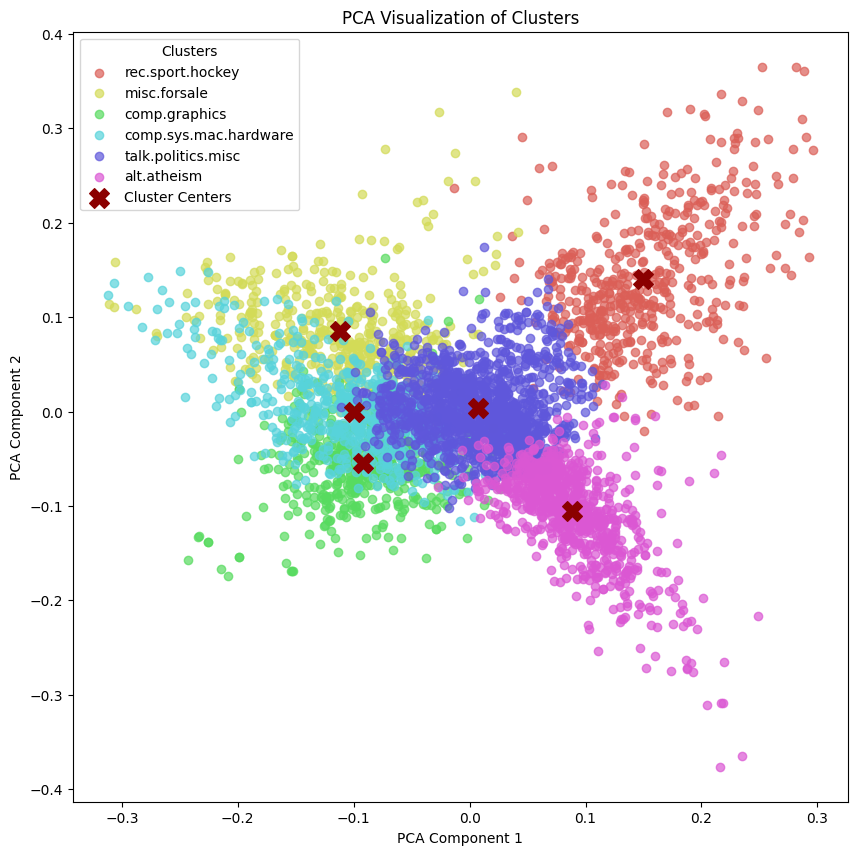

In [59]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=2048)
X_train_vectorized = vectorizer.fit_transform(X_train)
pca = PCA(n_components=.9, random_state=42)
X_train_pca = pca.fit_transform(X_train_vectorized.toarray())
model = KMeans(n_clusters=n_categories, random_state=42)
model.fit(X_train_pca)
y_pred = model.predict(X_train_pca)
silhouette_avg = silhouette_score(X_train_pca, y_pred)
purity = purity_score(y_train, y_pred)
labels = assign_clusters(y_train, y_pred)
print(f"Silhouette score = {silhouette_avg:.4f}, Purity = {purity:.4f}")
pca_visualization(X_train_pca, y_pred, model.cluster_centers_, labels)

## Test data evaluation

Silhouette score = 0.0048, Purity = 0.5579


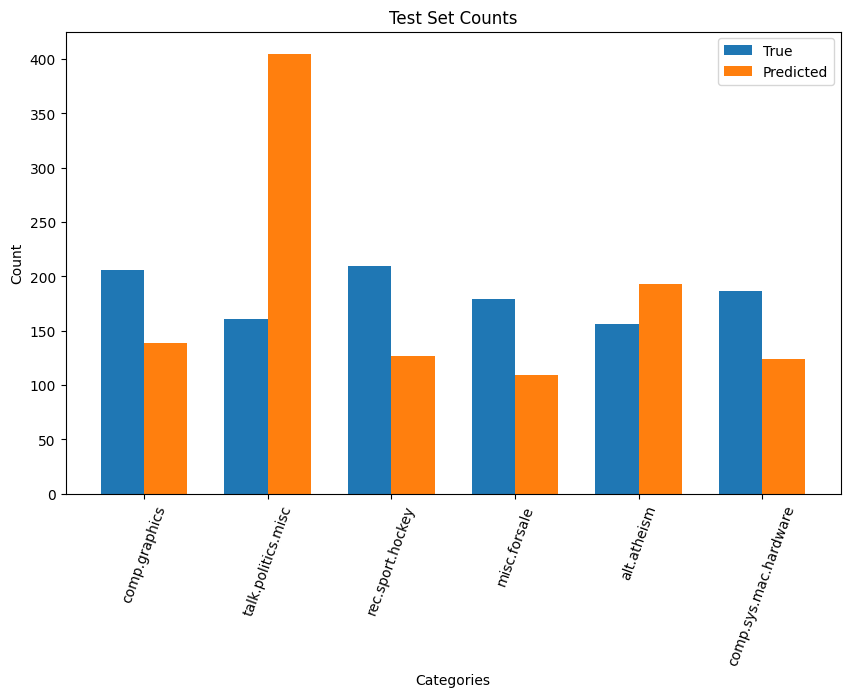

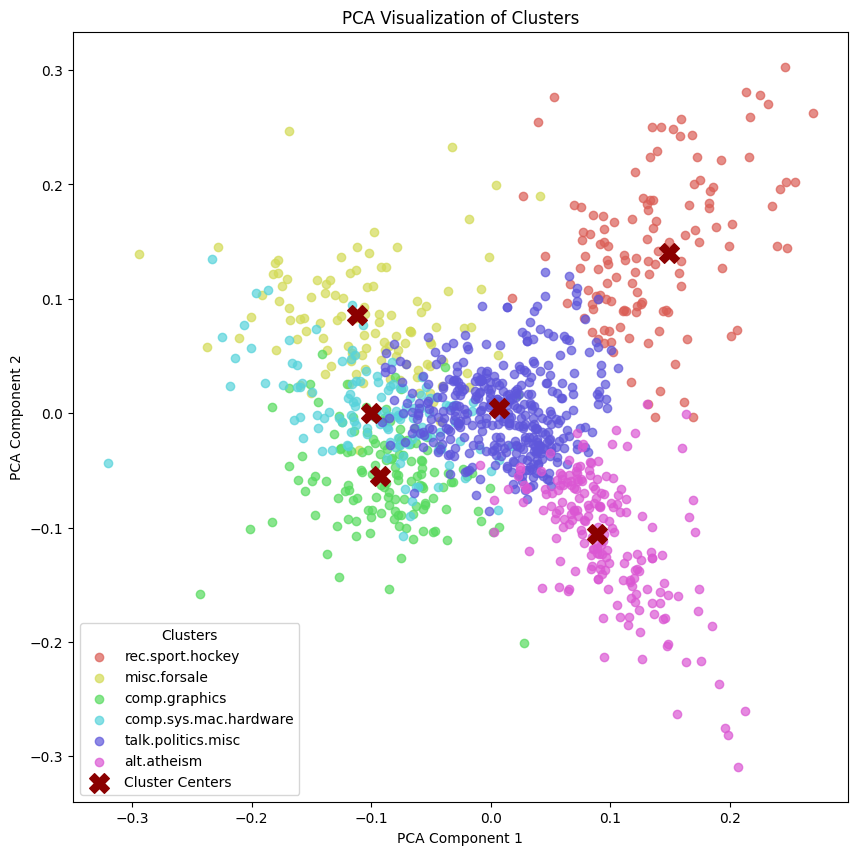

In [60]:
X_test_vectorized = vectorizer.transform(X_test)
X_test_pca = pca.transform(X_test_vectorized.toarray())
y_pred = model.predict(X_test_pca)
silhouette_avg = silhouette_score(X_test_pca, y_pred)
purity = purity_score(y_test, y_pred)
labels = assign_clusters(y_test, y_pred)
print(f"Silhouette score = {silhouette_avg:.4f}, Purity = {purity:.4f}")
visualize_counts(y_test, y_pred, 'Test Set Counts')
pca_visualization(X_test_pca, y_pred, model.cluster_centers_, labels)